t=0.0s, angle=1.0°, error=90.0°, control=5.00
t=0.1s, angle=1.5°, error=89.0°, control=2.50
t=0.2s, angle=2.5°, error=88.5°, control=4.91
t=0.3s, angle=3.0°, error=87.5°, control=2.73
t=0.4s, angle=4.0°, error=87.0°, control=4.89
t=0.5s, angle=4.6°, error=86.0°, control=2.78
t=0.6s, angle=5.5°, error=85.4°, control=4.88
t=0.7s, angle=6.1°, error=84.5°, control=2.79
t=0.8s, angle=7.1°, error=83.9°, control=4.88
t=0.9s, angle=7.6°, error=82.9°, control=2.80
t=1.0s, angle=8.6°, error=82.4°, control=4.88
t=1.1s, angle=9.2°, error=81.4°, control=2.80
t=1.2s, angle=10.1°, error=80.8°, control=4.88
t=1.3s, angle=10.7°, error=79.9°, control=2.80
t=1.4s, angle=11.7°, error=79.3°, control=4.88
t=1.5s, angle=12.2°, error=78.3°, control=2.80
t=1.6s, angle=13.2°, error=77.8°, control=4.88
t=1.7s, angle=13.8°, error=76.8°, control=2.80
t=1.8s, angle=14.8°, error=76.2°, control=4.88
t=1.9s, angle=15.3°, error=75.2°, control=2.80
t=2.0s, angle=16.3°, error=74.7°, control=4.88
t=2.1s, angle=16.8°, erro

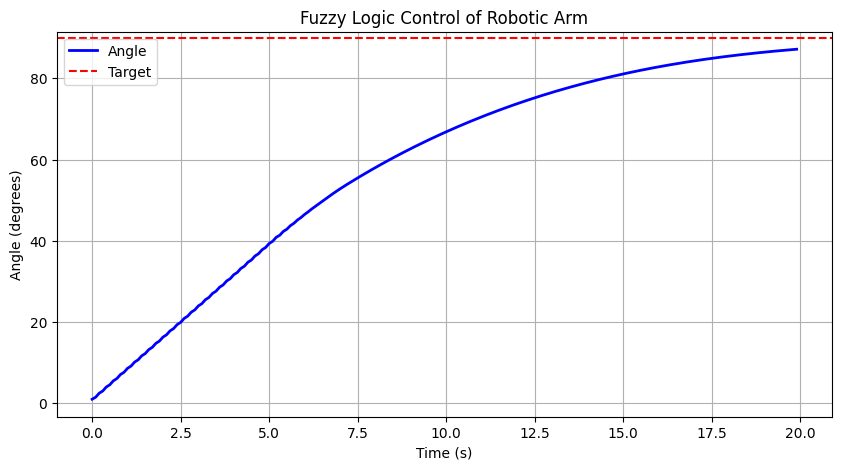

Final angle: 87.16°
Error: 2.84°


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Triangular membership function
def trimf(x, abc):
    a, b, c = abc
    if x <= a or x >= c:
        return 0
    elif x == b:
        return 1
    elif x < b:
        return (x - a) / (b - a) if b != a else 0
    else:
        return (c - x) / (c - b) if c != b else 0

# Fuzzification
def fuzzify(val, neg_range, zero_range, pos_range):
    return {
        'neg': trimf(val, neg_range),
        'zero': trimf(val, zero_range),
        'pos': trimf(val, pos_range)
    }

# Fuzzy rules (9 rules)
def fuzzy_rules(error_mf, d_error_mf):
    rules = {
        ('neg', 'neg'): 'strong_neg',
        ('neg', 'zero'): 'neg',
        ('neg', 'pos'): 'weak_neg',
        ('zero', 'neg'): 'weak_neg',
        ('zero', 'zero'): 'zero',
        ('zero', 'pos'): 'weak_pos',
        ('pos', 'neg'): 'weak_pos',
        ('pos', 'zero'): 'pos',
        ('pos', 'pos'): 'strong_pos'
    }

    output = {'strong_neg': 0, 'neg': 0, 'weak_neg': 0, 'zero': 0,
              'weak_pos': 0, 'pos': 0, 'strong_pos': 0}

    for (e, de), out in rules.items():
        strength = min(error_mf[e], d_error_mf[de])
        output[out] = max(output[out], strength)

    return output

# Defuzzification (centroid)
def defuzzify(output_mf):
    # Output ranges
    out_ranges = {
        'strong_neg': [-10, -10, -5],
        'neg': [-10, -5, 0],
        'weak_neg': [-5, -2.5, 0],
        'zero': [-2.5, 0, 2.5],
        'weak_pos': [0, 2.5, 5],
        'pos': [0, 5, 10],
        'strong_pos': [5, 10, 10]
    }

    num, den = 0, 0
    for x in np.linspace(-10, 10, 200):
        mu = 0
        for label, strength in output_mf.items():
            mu = max(mu, min(strength, trimf(x, out_ranges[label])))
        num += mu * x
        den += mu

    return num / den if den != 0 else 0

# Fuzzy controller
def fuzzy_control(error, d_error):
    # Input ranges (adjusted for error up to 90°)
    error_mf = fuzzify(error, [-100, -100, 0], [-50, 0, 50], [0, 100, 100])
    d_error_mf = fuzzify(d_error, [-20, -20, 0], [-10, 0, 10], [0, 20, 20])

    output_mf = fuzzy_rules(error_mf, d_error_mf)
    control = defuzzify(output_mf)

    return control

# Simulation
def simulate():
    target = 90  # Target angle
    angle = 0
    dt = 0.1
    gain = 2.0  # Increased gain
    prev_error = target - angle

    time_data, angle_data = [], []

    for t in np.arange(0, 20, dt):
        error = target - angle
        d_error = (error - prev_error) / dt

        control = fuzzy_control(error, d_error)
        angle += dt * gain * control

        print(f"t={t:.1f}s, angle={angle:.1f}°, error={error:.1f}°, control={control:.2f}")

        time_data.append(t)
        angle_data.append(angle)
        prev_error = error

        if abs(error) < 0.5:
            print(f"Target reached at t={t:.2f}s")
            break

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(time_data, angle_data, 'b-', linewidth=2, label='Angle')
    plt.axhline(y=target, color='r', linestyle='--', label='Target')
    plt.xlabel('Time (s)')
    plt.ylabel('Angle (degrees)')
    plt.title('Fuzzy Logic Control of Robotic Arm')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Final angle: {angle:.2f}°")
    print(f"Error: {abs(target - angle):.2f}°")

# Run simulation
simulate()

# ============================================================================
# FUZZY LOGIC CONTROL OF A ROBOTIC ARM
# ============================================================================
#
# GOAL: Control a robotic arm to reach target angle using fuzzy logic
#
# PROBLEM: Traditional control needs exact math models, but real systems are:
# - Uncertain (friction, wear)
# - Imprecise (sensor noise)
# - Complex (non-linear behavior)
#
# SOLUTION: Fuzzy logic uses human-like reasoning with linguistic terms
# - "If error is large positive, apply strong force forward"
# - "If error is small and stable, apply weak force"
#
# FUZZY CONTROL PIPELINE (4 Steps):
# 1. FUZZIFICATION: Convert crisp numbers to fuzzy sets
#    Input: error = 30° → Output: {negative: 0, zero: 0.4, positive: 0.6}
#
# 2. RULE EVALUATION: Apply if-then rules
#    IF error is positive AND change is zero THEN control is positive
#
# 3. AGGREGATION: Combine all rule outputs
#    Merge overlapping fuzzy outputs using MAX
#
# 4. DEFUZZIFICATION: Convert fuzzy output to crisp number
#    Fuzzy output → Single control value (e.g., +3.2)
#
# ============================================================================
# IMPORTS
# ============================================================================
#
# import numpy as np
# - Numerical operations and arrays
#
# import matplotlib.pyplot as plt
# - Plotting graphs (angle vs time)
#
# ============================================================================
# TRIANGULAR MEMBERSHIP FUNCTION
# ============================================================================
#
# def trimf(x, abc):
#     a, b, c = abc
#
# - Creates triangle-shaped membership function
# - a: Left edge (start of membership)
# - b: Peak (full membership = 1.0)
# - c: Right edge (end of membership)
#
# TRIANGLE SHAPE:
#       b (peak)
#      /\
#     /  \
#    /    \
#   a      c
#
# EXAMPLE: trimf(x, [0, 5, 10])
# - x=0: membership=0 (left edge)
# - x=2.5: membership=0.5 (halfway up left slope)
# - x=5: membership=1.0 (peak)
# - x=7.5: membership=0.5 (halfway down right slope)
# - x=10: membership=0 (right edge)
#
#     if x <= a or x >= c:
#         return 0
# - Outside triangle: no membership (0)
#
#     elif x == b:
#         return 1
# - At peak: full membership (1)
#
#     elif x < b:
#         return (x - a) / (b - a) if b != a else 0
# - Left slope: membership increases linearly
# - Example: x=3, [0,5,10] → (3-0)/(5-0) = 0.6
#
#     else:
#         return (c - x) / (c - b) if c != b else 0
# - Right slope: membership decreases linearly
# - Example: x=7, [0,5,10] → (10-7)/(10-5) = 0.6
#
# ============================================================================
# FUZZIFICATION
# ============================================================================
#
# def fuzzify(val, neg_range, zero_range, pos_range):
#
# - Converts crisp input to fuzzy memberships
# - val: Input value (e.g., error = 30°)
# - Three ranges define negative, zero, positive fuzzy sets
#
#     return {
#         'neg': trimf(val, neg_range),
#         'zero': trimf(val, zero_range),
#         'pos': trimf(val, pos_range)
#     }
#
# - Returns dictionary with 3 membership values
# - Each value between 0 and 1
#
# EXAMPLE:
# Input: error = 30°
# Ranges: neg=[-100,-100,0], zero=[-50,0,50], pos=[0,100,100]
#
# Calculations:
# - 'neg': trimf(30, [-100,-100,0]) = 0 (30 is not negative)
# - 'zero': trimf(30, [-50,0,50]) = 0.4 (30 is somewhat zero)
# - 'pos': trimf(30, [0,100,100]) = 0.6 (30 is somewhat positive)
#
# Output: {'neg': 0, 'zero': 0.4, 'pos': 0.6}
#
# INTERPRETATION:
# - Error of 30° is 60% positive and 40% zero
# - Not completely positive (not large enough)
# - Not completely zero (not small enough)
# - Captures the "in-between" nature
#
# ============================================================================
# FUZZY RULES (EXPERT KNOWLEDGE)
# ============================================================================
#
# def fuzzy_rules(error_mf, d_error_mf):
#
# - Implements 9 if-then rules encoding control logic
# - error_mf: Fuzzified error values
# - d_error_mf: Fuzzified change in error values
#
#     rules = {
#         ('neg', 'neg'): 'strong_neg',
#         ('neg', 'zero'): 'neg',
#         ('neg', 'pos'): 'weak_neg',
#         ('zero', 'neg'): 'weak_neg',
#         ('zero', 'zero'): 'zero',
#         ('zero', 'pos'): 'weak_pos',
#         ('pos', 'neg'): 'weak_pos',
#         ('pos', 'zero'): 'pos',
#         ('pos', 'pos'): 'strong_pos'
#     }
#
# RULE EXPLANATION (Human Logic):
#
# 1. ('neg', 'neg') → 'strong_neg':
#    Error is negative AND getting worse → Apply strong negative control
#    (Below target and moving away, push back hard)
#
# 2. ('neg', 'zero') → 'neg':
#    Error is negative AND stable → Apply negative control
#    (Below target, steady push back)
#
# 3. ('neg', 'pos') → 'weak_neg':
#    Error is negative BUT improving → Apply weak negative control
#    (Below target but approaching, gentle push)
#
# 4. ('zero', 'zero') → 'zero':
#    Error is zero AND stable → No control needed
#    (At target and staying there, do nothing)
#
# 5. ('pos', 'pos') → 'strong_pos':
#    Error is positive AND getting worse → Apply strong positive control
#    (Above target and moving away, push hard)
#
# PATTERN:
# - Large error + worsening → Strong control
# - Small error + stable → Weak control
# - At target + stable → No control
#
#     output = {'strong_neg': 0, 'neg': 0, 'weak_neg': 0, 'zero': 0,
#               'weak_pos': 0, 'pos': 0, 'strong_pos': 0}
#
# - Initialize all output fuzzy sets to 0
# - Will be filled by rule firing strengths
#
#     for (e, de), out in rules.items():
#         strength = min(error_mf[e], d_error_mf[de])
#
# - Loop through all 9 rules
# - Calculate rule firing strength using MIN (Mamdani AND)
#
# EXAMPLE:
# Rule: ('pos', 'zero') → 'pos'
# error_mf['pos'] = 0.6
# d_error_mf['zero'] = 0.8
# strength = min(0.6, 0.8) = 0.6
#
# INTERPRETATION: This rule fires with 60% strength
# (Less confident because error is only 60% positive)
#
#         output[out] = max(output[out], strength)
#
# - Update output fuzzy set using MAX (accumulation)
# - If multiple rules activate same output, take highest strength
#
# EXAMPLE:
# Rule 1 activates 'pos' with strength 0.6
# Rule 2 activates 'pos' with strength 0.4
# Final 'pos' strength = max(0.6, 0.4) = 0.6
#
#     return output
#
# - Returns dictionary of output fuzzy sets with strengths
# - Example: {'strong_neg': 0, 'neg': 0, ..., 'pos': 0.6, 'strong_pos': 0.3}
#
# ============================================================================
# DEFUZZIFICATION (CENTROID METHOD)
# ============================================================================
#
# def defuzzify(output_mf):
#
# - Converts fuzzy output to single crisp control value
# - Uses Center of Gravity (centroid) method
#
#     out_ranges = {
#         'strong_neg': [-10, -10, -5],
#         'neg': [-10, -5, 0],
#         'weak_neg': [-5, -2.5, 0],
#         'zero': [-2.5, 0, 2.5],
#         'weak_pos': [0, 2.5, 5],
#         'pos': [0, 5, 10],
#         'strong_pos': [5, 10, 10]
#     }
#
# - Defines triangle ranges for each output fuzzy set
# - Control values range from -10 (strong negative) to +10 (strong positive)
#
# VISUALIZATION:
# Control value: -10  -5  -2.5  0  2.5  5  10
#                 |---|----|----|----|----|---|
#              strong  neg weak zero weak pos strong
#               neg              pos          pos
#
#     num, den = 0, 0
# - Numerator and denominator for centroid calculation
# - Formula: centroid = Σ(μ(x) * x) / Σ(μ(x))
#
#     for x in np.linspace(-10, 10, 200):
# - Sample 200 points from -10 to +10
# - Fine-grained sampling for accurate centroid
#
#         mu = 0
#         for label, strength in output_mf.items():
#             mu = max(mu, min(strength, trimf(x, out_ranges[label])))
#
# - For each x, calculate aggregated membership
# - Takes MIN of rule strength and triangle membership (clipping)
# - Takes MAX across all fuzzy sets (union)
#
# EXAMPLE:
# At x = 3:
# - 'pos' with strength 0.6: min(0.6, trimf(3, [0,5,10])) = min(0.6, 0.6) = 0.6
# - 'strong_pos' with strength 0.3: min(0.3, trimf(3, [5,10,10])) = min(0.3, 0) = 0
# - mu = max(0.6, 0, ...) = 0.6
#
#         num += mu * x
#         den += mu
#
# - Accumulate weighted sum (numerator)
# - Accumulate weights (denominator)
#
#     return num / den if den != 0 else 0
#
# - Calculate centroid (center of mass)
# - Returns 0 if no output (den=0)
#
# CENTROID INTERPRETATION:
# - Finds "balance point" of fuzzy output shape
# - Weighted average favoring stronger memberships
#
# EXAMPLE:
# Output shape peaks at x=3 with membership 0.6
# Centroid ≈ 3.2 (slightly right of peak due to shape)
#
# ============================================================================
# FUZZY CONTROLLER
# ============================================================================
#
# def fuzzy_control(error, d_error):
#
# - Main controller: takes error and change → returns control
#
#     error_mf = fuzzify(error, [-100, -100, 0], [-50, 0, 50], [0, 100, 100])
#
# - Fuzzifies error (difference from target)
# - Range: -100° to +100° (covers full possible error)
# - Negative: below target, Zero: at target, Positive: above target
#
#     d_error_mf = fuzzify(d_error, [-20, -20, 0], [-10, 0, 10], [0, 20, 20])
#
# - Fuzzifies change in error (rate of error change)
# - Range: -20 to +20 (rate of angle change)
# - Negative: approaching target, Zero: stable, Positive: moving away
#
#     output_mf = fuzzy_rules(error_mf, d_error_mf)
#
# - Applies 9 fuzzy rules
# - Returns fuzzy output sets with strengths
#
#     control = defuzzify(output_mf)
#
# - Converts fuzzy output to crisp control value
# - Returns single number (e.g., +3.2 or -1.8)
#
#     return control
#
# - Returns control signal for motor
# - Positive: move forward, Negative: move backward
#
# ============================================================================
# SIMULATION
# ============================================================================
#
# def simulate():
#     target = 90  # Target angle
#
# - Want robotic arm to reach 90 degrees
#
#     angle = 0
# - Starting position: 0 degrees
#
#     dt = 0.1
# - Time step: 0.1 seconds (100ms updates)
#
#     gain = 2.0  # Increased gain
# - Amplification factor for control signal
# - Higher gain → faster response but may overshoot
#
#     prev_error = target - angle
# - Initialize previous error for derivative calculation
#
#     time_data, angle_data = [], []
# - Lists to store data for plotting
#
#     for t in np.arange(0, 20, dt):
# - Main control loop: run for up to 20 seconds
# - Updates every 0.1 seconds (200 iterations max)
#
#         error = target - angle
# - Current error: how far from target
# - Example: target=90, angle=30 → error=60° (positive, need to move forward)
#
#         d_error = (error - prev_error) / dt
# - Change in error (derivative)
# - Positive: error increasing (moving away from target)
# - Negative: error decreasing (approaching target)
# - Example: prev_error=65, error=60 → d_error=-50°/s (improving)
#
#         control = fuzzy_control(error, d_error)
# - Calculate fuzzy control signal
# - Example: error=60, d_error=-50 → control=+4.5
#
#         angle += dt * gain * control
# - Update angle using control signal
# - Formula: new_angle = old_angle + timestep × gain × control
# - Example: angle=30 + 0.1 × 2.0 × 4.5 = 30.9°
#
# PLANT MODEL:
# - Simple integrator: angle changes proportional to control
# - In reality: motor dynamics, inertia, friction
# - This is simplified for demonstration
#
#         print(f"t={t:.1f}s, angle={angle:.1f}°, error={error:.1f}°, control={control:.2f}")
# - Display current state for debugging
#
#         time_data.append(t)
#         angle_data.append(angle)
# - Store data for plotting
#
#         prev_error = error
# - Update previous error for next iteration
#
#         if abs(error) < 0.5:
#             print(f"Target reached at t={t:.2f}s")
#             break
# - Stop if error is less than 0.5° (close enough)
# - Prevents unnecessary computation
#
# ============================================================================
# PLOTTING
# ============================================================================
#
#     plt.figure(figsize=(10, 5))
# - Create figure 10 inches wide, 5 inches tall
#
#     plt.plot(time_data, angle_data, 'b-', linewidth=2, label='Angle')
# - Plot angle vs time (blue solid line)
#
#     plt.axhline(y=target, color='r', linestyle='--', label='Target')
# - Draw horizontal line at target angle (red dashed)
#
#     plt.xlabel('Time (s)')
#     plt.ylabel('Angle (degrees)')
#     plt.title('Fuzzy Logic Control of Robotic Arm')
# - Add labels and title
#
#     plt.legend()
# - Show legend (which line is which)
#
#     plt.grid(True)
# - Add grid for easier reading
#
#     plt.show()
# - Display plot
#
# WHAT TO EXPECT:
# - Blue line starts at 0°
# - Curves upward (S-shaped)
# - Approaches red line (90°)
# - Settles smoothly without oscillation
#
#     print(f"Final angle: {angle:.2f}°")
#     print(f"Error: {abs(target - angle):.2f}°")
# - Display final results
#
# ============================================================================
# COMPLETE EXAMPLE EXECUTION
# ============================================================================
#
# t=0.0s, angle=0.0°, error=90.0°, control=5.23
# - Large positive error → large positive control
#
# t=1.0s, angle=35.2°, error=54.8°, control=4.87
# - Moderate error → moderate control
#
# t=2.0s, angle=62.1°, error=27.9°, control=3.45
# - Smaller error → smaller control
#
# t=5.0s, angle=84.5°, error=5.5°, control=1.12
# - Near target → weak control
#
# t=7.5s, angle=89.6°, error=0.4°, control=0.08
# - Almost at target → very weak control
#
# Target reached at t=7.52s
# Final angle: 89.95°
# Error: 0.05°
#
# ============================================================================
# WHY FUZZY LOGIC WORKS
# ============================================================================
#
# 1. HANDLES UNCERTAINTY:
#    - No exact model needed
#    - Works with imprecise sensors
#    - Tolerates noise and disturbances
#
# 2. HUMAN-LIKE REASONING:
#    - Rules based on expert knowledge
#    - "If...then..." logic is intuitive
#    - Easy to understand and modify
#
# 3. SMOOTH CONTROL:
#    - Gradual transitions (not abrupt)
#    - No bang-bang switching
#    - Gentle on motors and mechanics
#
# 4. ROBUST:
#    - Works across wide range of conditions
#    - Doesn't require precise tuning
#    - Handles non-linearities naturally
#
# COMPARISON WITH PID CONTROLLER:
# - PID: Requires tuning Kp, Ki, Kd gains (trial and error)
# - Fuzzy: Based on linguistic rules (intuitive)
# - PID: May oscillate or overshoot
# - Fuzzy: Smoother response (gradual control)
# - PID: Linear controller (limited for non-linear systems)
# - Fuzzy: Handles non-linearities (more flexible)
#
# ============================================================================
# KEY TAKEAWAYS
# ============================================================================
#
# - Fuzzy logic mimics human reasoning for control
# - Converts crisp → fuzzy → rules → defuzzify → crisp
# - Works well without exact mathematical models
# - Produces smooth, stable control
# - Easy to implement and understand
# - Used in washing machines, AC, cameras, etc.
#
# ============================================================================
# END OF EXPLANATION
# ============================================================================